
##Importing Libraries



In [ ]:
from scipy.signal import butter, filtfilt, decimate, find_peaks
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import cv2
import math

import joblib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Load datasets for each person

In [ ]:
s1_train = pd.read_csv('train/s1.txt')
s1_test = pd.read_csv('test/s1.txt')

s2_train = pd.read_csv('train/s2.txt')
s2_test = pd.read_csv('test/s2.txt')

s3_train = pd.read_csv('train/s3.txt')
s3_test = pd.read_csv('test/s3.txt')

##Functions

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Apply the filter to the signal
def apply_filter(data):
    b, a = butter_bandpass(low_cutoff, high_cutoff, sampling_rate, order)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

In [ ]:
def downsampling(normalized_signal, downsampling_factor):
    downsampling_factor = int(downsampling_factor)
    resampled_signal = normalized_signal[::downsampling_factor]
    return resampled_signal

In [ ]:
def autoCorrelation(samples):
    r = []
    N = len(samples)

    for j in range(0, N): #The process repeats for all possible lags from 0 to N-1
        autocorrelation_sum = 0
        for n in range(0, N):
            shifted_index = n + j #For each lag j, the signal is shifted by j indices
            if (shifted_index >= N):
                shifted_index -= N
            autocorrelation_sum += (samples[n] * samples[shifted_index])
        r.append(autocorrelation_sum / N) #/N: to normalize the result

    return r

In [ ]:
def dct(signal):
    result=[]
    N=len(signal)
    for k in range(0, 15):
        summation = 0
        for n in range(0, 15):
            summation += signal[n] * math.cos((math.pi / (4 * 15) * (2 * n - 1) * (2 * k - 1)))

        result.append(math.sqrt(2 / 15) * summation)
    return result

In [ ]:
def DFconstruction(S_features,name):
    num_features = len(S_features[0])
    column_names = [f"F{i+1}" for i in range(num_features)]
    df = pd.DataFrame(S_features, columns=column_names)

    df['target'] = name
    return df

##Data Preprocessing

In [ ]:
#Parameters
sampling_rate = 1000
target_sampling_rate = 500
low_cutoff = 1
high_cutoff = 40
order = 4
downsample_factor = sampling_rate / target_sampling_rate #determines how much the signal will be compressed

In [ ]:
def preprocessing(df,height=0.75,distance=100):
    signal = df.values.flatten()

    #mean removal (=remove dct component time domain)
    mean_value = np.mean(signal)
    signal_centered = signal - mean_value
    filtered_signal = apply_filter(signal_centered)

    #[-1,1]
    # normalized_signal = (filtered_signal - np.min(filtered_signal)) / (np.max(filtered_signal) - np.min(filtered_signal)) #->[0,1] which is wrong
    normalized_signal = 2 * (filtered_signal - np.min(filtered_signal)) / (np.max(filtered_signal) - np.min(filtered_signal)) - 1 #[-1,1]
    #normalizedsignal = cv2.normalize(filtered_signal, None, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    #normalized_signal = normalizedsignal.flatten()

    downsampled_signal = downsampling(normalized_signal, downsample_factor) #to reduce computation
    print(len(downsampled_signal))
    #plotting for down sampled
    signal_limited = downsampled_signal[:1000] #limiting for plotting only

    #Segmentation
    peaks, _ = find_peaks(downsampled_signal, height=height, distance=distance) #R-peaks
    num_segments = len(peaks) / 4
    num_segments = int(num_segments)
    segments = []
    for i in range(num_segments):
        start_index = peaks[i * 4]
        end_index = peaks[(i + 1) * 4 - 1]
        segment = downsampled_signal[start_index:end_index + 1]
        segments.append(segment)

    dct_coefficients = []
    for segment in segments:
        autocorrelation = autoCorrelation(segment)
        #autocorrelation=np.correlate(segment,segment, mode='full')
        #coefficients = dct(autocorrelation)
        coefficients = dct(autocorrelation)
        dct_coefficients.append(coefficients[0:15])

    return dct_coefficients, signal_limited, segments #features - non zero

In [ ]:
S1_features,signal1_limited,segments1=preprocessing(s1_train)
S2_features,signal2_limited,_=preprocessing(s2_train)
S3_features,signal3_limited,_=preprocessing(s3_train)

11520
11520
12001


In [ ]:
#Test:
S1_test_ft,signal1_limited_test,_=preprocessing(s1_test)
S2_test_ft,signal2_limited_test,_=preprocessing(s2_test,0.19)
S3_test_ft,signal3_limited_test,_=preprocessing(s3_test)

11520
11520
12001


###Plotting

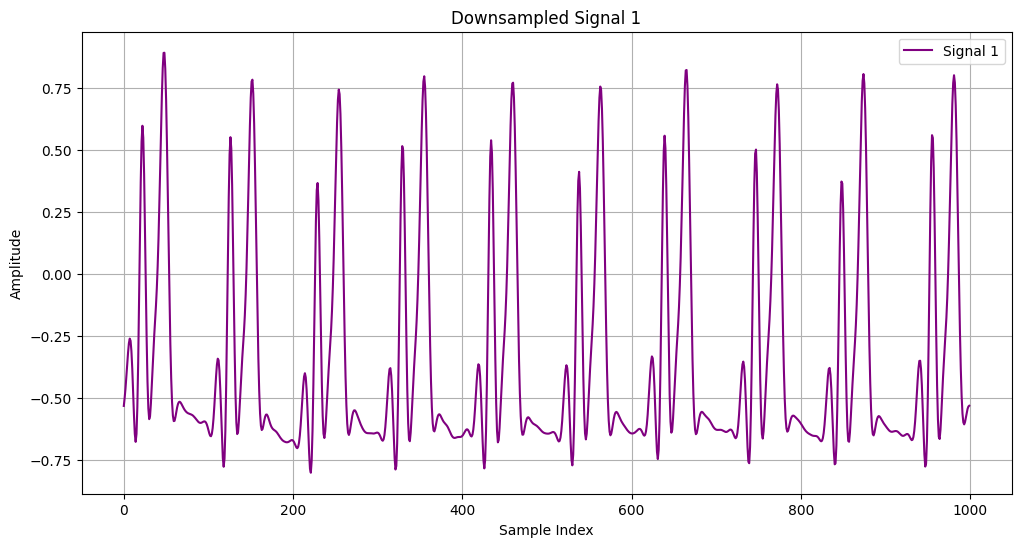

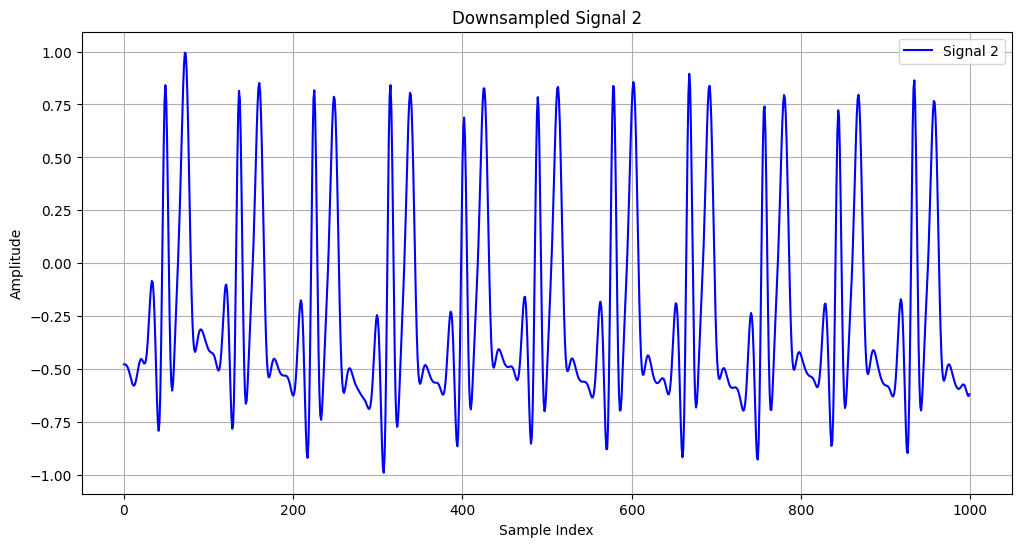

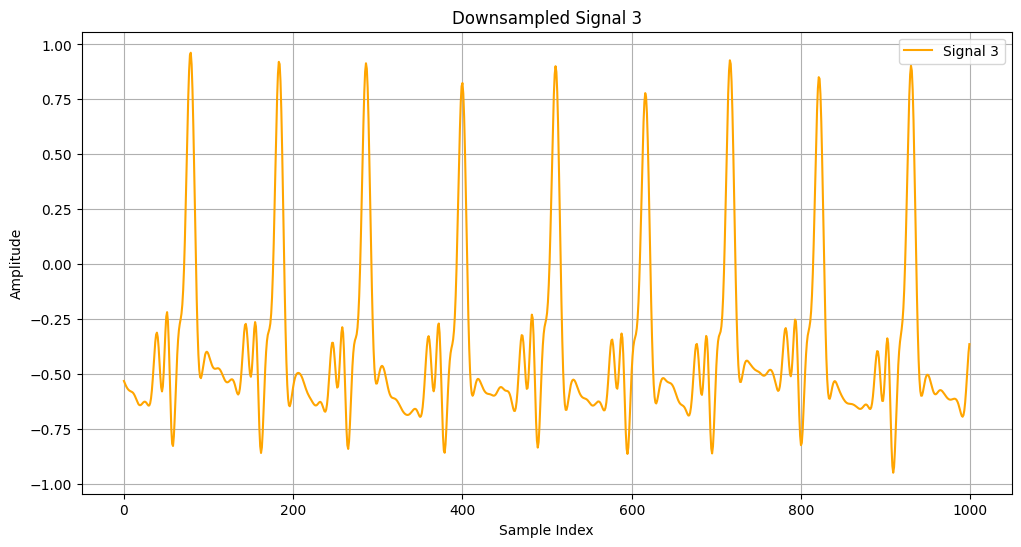

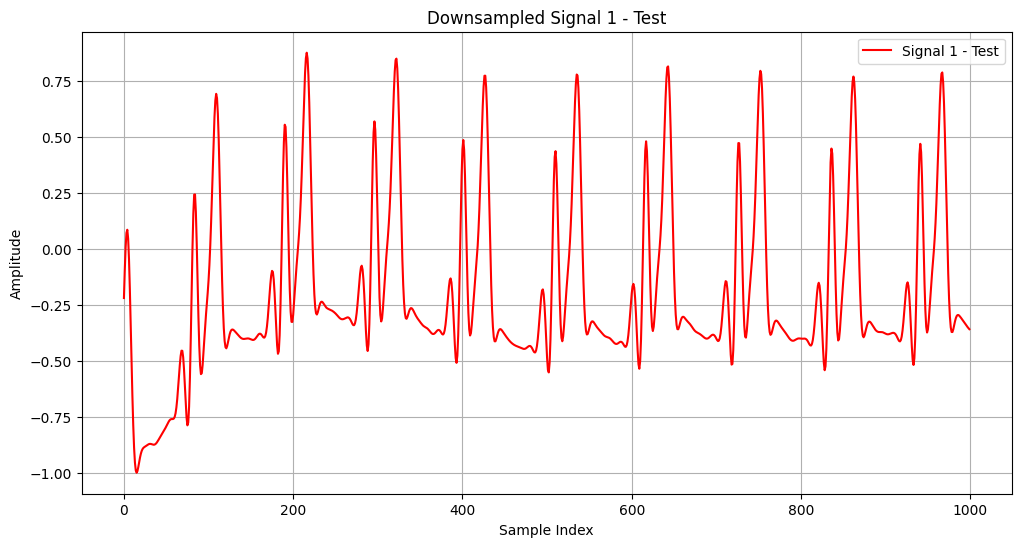

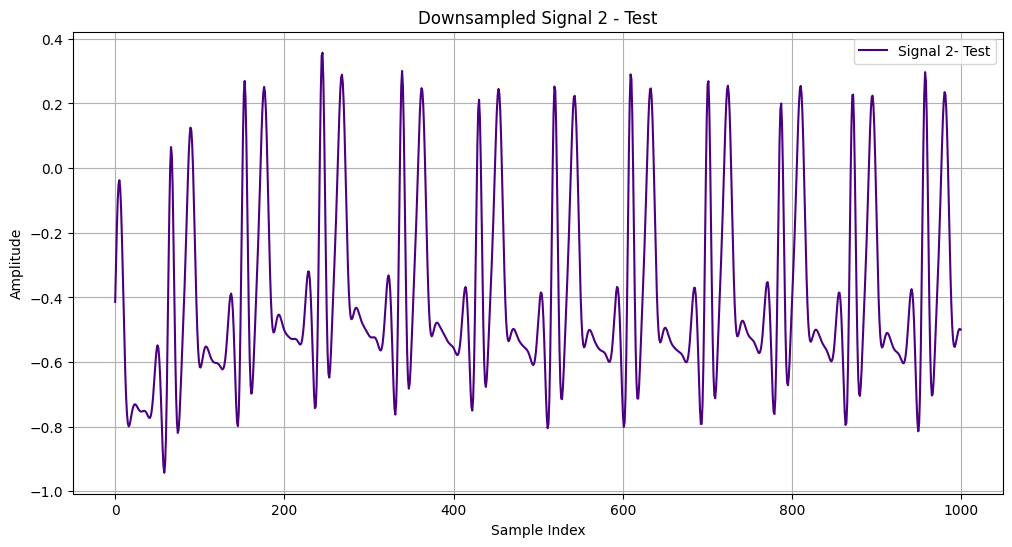

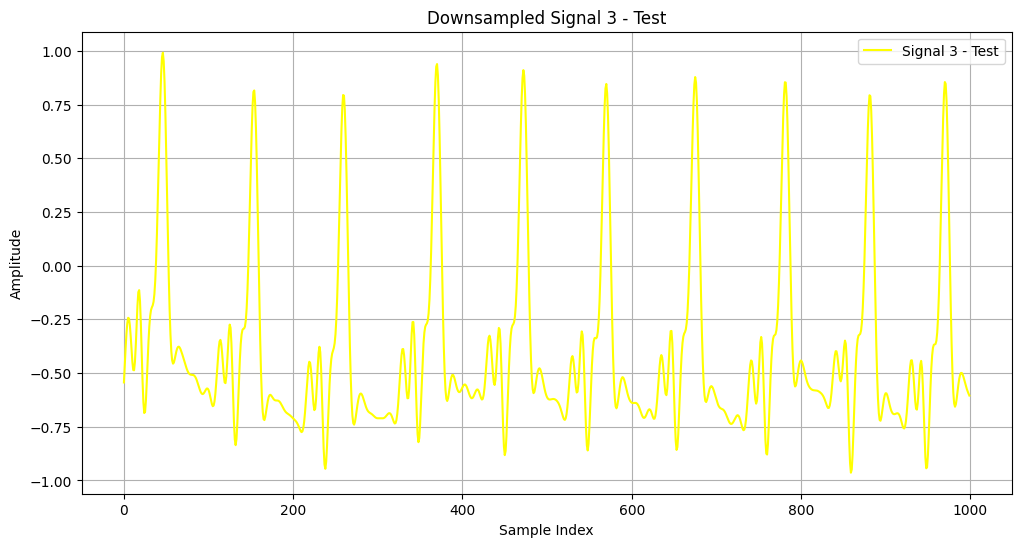

In [ ]:
def plot_signal(signal, title='Signal', color='purple', label='Signal'):
    plt.figure(figsize=(12, 6))
    plt.plot(signal, label=label, color=color)
    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

#normalized signal plotting to determine the height and distance of the peak finding process
plot_signal(signal1_limited,'Downsampled Signal 1','purple','Signal 1')
plot_signal(signal2_limited,'Downsampled Signal 2','blue','Signal 2')
plot_signal(signal3_limited,'Downsampled Signal 3','orange','Signal 3')
plot_signal(signal1_limited_test,'Downsampled Signal 1 - Test','red','Signal 1 - Test')
plot_signal(signal2_limited_test,'Downsampled Signal 2 - Test','indigo','Signal 2- Test')
plot_signal(signal3_limited_test,'Downsampled Signal 3 - Test','yellow','Signal 3 - Test')

. Therefore, height of peaks=0.75, distance between 2 peaks=100:

peaks, _ = find_peaks(downsampled_signal, height=0.75, distance=50) #R-peaks

(The distance between the two R-peaks is approximately 100 samples, as the beats are of similar length and the R-peak timing follows a typical pattern)

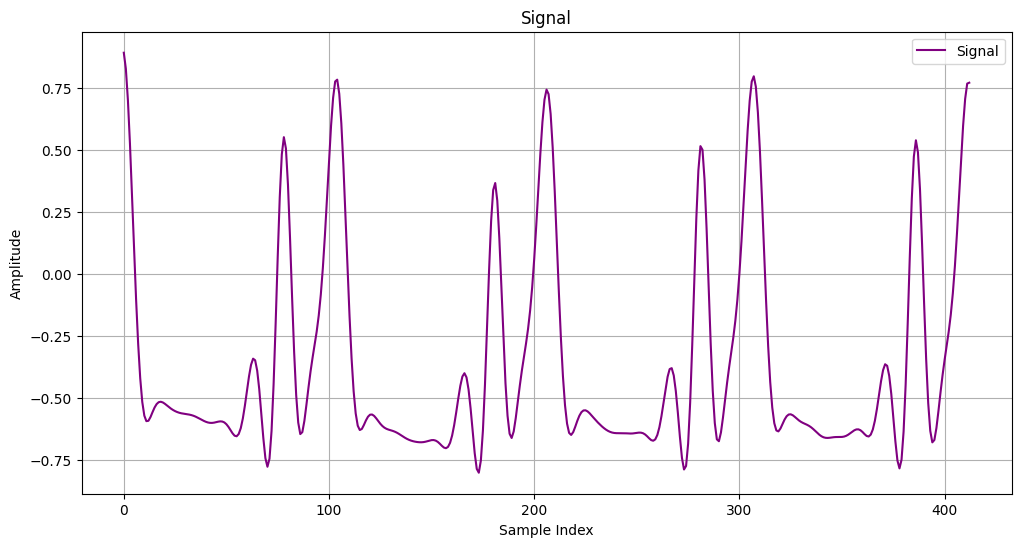

In [ ]:
plot_signal(segments1[0]) #each segment contains 4 heartbeats

##Dataset Construction

In [ ]:
dfS1=DFconstruction(S1_features,'MK')
dfS2=DFconstruction(S2_features,'Mostafa')
dfS3=DFconstruction(S3_features,'Mariam')

In [ ]:
dfS1_test=DFconstruction(S1_test_ft,'MK')
dfS2_test=DFconstruction(S2_test_ft,'Mostafa')
dfS3_test=DFconstruction(S3_test_ft,'Mariam')

In [ ]:
dfS1.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,target
0,0.847758,0.847758,0.113819,0.219482,0.057890,0.132824,0.076812,0.095679,0.079410,0.064415,0.072630,0.035234,0.059141,0.007640,0.040493,MK
1,0.841060,0.841060,0.113653,0.213269,0.058564,0.130499,0.076455,0.094384,0.078597,0.063813,0.071619,0.035173,0.058103,0.008012,0.039564,MK
2,0.857781,0.857781,0.097566,0.218458,0.055200,0.132818,0.075433,0.095104,0.078798,0.063521,0.072580,0.034194,0.059525,0.006593,0.041205,MK
3,0.843005,0.843005,0.111629,0.216521,0.057431,0.131547,0.076183,0.094799,0.078734,0.063842,0.071995,0.034935,0.058611,0.007593,0.040119,MK
4,0.859324,0.859324,0.106995,0.220893,0.057134,0.133844,0.076819,0.096155,0.079780,0.064506,0.073195,0.035033,0.059792,0.007220,0.041143,MK


In [ ]:
dfS2.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,target
0,0.554501,0.554501,0.289733,0.197323,0.072813,0.110832,0.075993,0.085194,0.070733,0.062433,0.059666,0.039805,0.044303,0.017165,0.025740,Mostafa
1,0.575697,0.575697,0.271824,0.207250,0.068555,0.114833,0.074970,0.086731,0.071379,0.062409,0.061309,0.038691,0.046504,0.015309,0.028143,Mostafa
2,0.542468,0.542468,0.296601,0.193754,0.074574,0.108860,0.076255,0.084317,0.070293,0.062266,0.058833,0.040154,0.043276,0.017883,0.024678,Mostafa
3,0.551454,0.551454,0.294910,0.192383,0.075225,0.109445,0.076592,0.084832,0.070632,0.062624,0.059159,0.040351,0.043554,0.017931,0.024873,Mostafa
4,0.523677,0.523677,0.302939,0.187775,0.075426,0.106276,0.075524,0.082891,0.069046,0.061623,0.057407,0.040139,0.041872,0.018389,0.023449,Mostafa


In [ ]:
dfS3.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,target
0,0.918535,0.918535,0.042015,0.199116,0.055701,0.128388,0.075249,0.092264,0.078393,0.061549,0.072172,0.032864,0.059265,0.005790,0.041209,Mariam
1,0.896123,0.896123,0.042857,0.192951,0.055222,0.124827,0.073773,0.089933,0.076569,0.060163,0.070322,0.032297,0.057609,0.005946,0.039920,Mariam
2,0.955293,0.955293,0.037331,0.206056,0.056999,0.132816,0.077589,0.095292,0.081038,0.063426,0.074742,0.033700,0.061492,0.005675,0.042886,Mariam
3,0.883337,0.883337,0.026739,0.191752,0.050967,0.122832,0.070774,0.087719,0.074451,0.058046,0.069000,0.030478,0.057043,0.004577,0.040069,Mariam
4,1.000647,1.000647,0.035323,0.217915,0.058013,0.139840,0.080506,0.099913,0.084644,0.066177,0.078405,0.034829,0.064772,0.005368,0.045439,Mariam


In [ ]:
#Combine and shuffle - Train
combined_df = pd.concat([dfS1, dfS2, dfS3], ignore_index=True)
df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

df.tail()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,target
57,0.955293,0.955293,0.037331,0.206056,0.056999,0.132816,0.077589,0.095292,0.081038,0.063426,0.074742,0.033700,0.061492,0.005675,0.042886,Mariam
58,0.835882,0.835882,0.129535,0.215874,0.061027,0.131378,0.078045,0.095471,0.079573,0.064971,0.072085,0.036275,0.058122,0.008953,0.039195,MK
59,0.527402,0.527402,0.320162,0.187626,0.079637,0.107159,0.078067,0.084376,0.070578,0.063312,0.058127,0.041791,0.041894,0.019824,0.022873,Mostafa
60,0.952208,0.952208,0.019088,0.205473,0.052071,0.132284,0.074582,0.093918,0.079294,0.061676,0.073994,0.031880,0.061572,0.004020,0.043648,Mariam
61,0.593819,0.593819,0.259261,0.195703,0.068783,0.112987,0.074703,0.085787,0.070905,0.061911,0.060776,0.038509,0.045998,0.015377,0.027730,Mostafa


In [ ]:
#Combine and shuffle - Test
combined_df_test = pd.concat([dfS1_test, dfS2_test, dfS3_test], ignore_index=True)
df_test = combined_df_test.sample(frac=1, random_state=42).reset_index(drop=True)

df_test.tail()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,target
56,1.000759,1.000759,0.029438,0.219569,0.056134,0.140206,0.079590,0.099737,0.084264,0.065716,0.078401,0.034224,0.065049,0.004721,0.045917,Mariam
57,0.368273,0.368273,0.111110,0.091583,0.040987,0.057961,0.042311,0.045136,0.039185,0.033176,0.033016,0.021074,0.024571,0.008865,0.014431,MK
58,0.648627,0.648627,0.026663,0.184563,0.022901,0.106920,0.047991,0.072050,0.056290,0.044556,0.055561,0.020315,0.048519,-0.001472,0.036553,Mostafa
59,1.061551,1.061551,0.023494,0.235965,0.056585,0.149608,0.083049,0.105735,0.088874,0.069124,0.083253,0.035426,0.069521,0.004010,0.049519,Mariam
60,0.720414,0.720414,0.011805,0.203680,0.023971,0.117433,0.052063,0.078582,0.061591,0.048158,0.061127,0.021448,0.053671,-0.002469,0.040749,Mostafa


##KNN Model

In [ ]:
X_train=df.drop("target",axis=1)
y_train=df["target"]

X_test=df_test.drop("target",axis=1)
y_test=df_test["target"]

In [ ]:
neighbor_range = range(1, 30)

for n in neighbor_range:
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(X_train, y_train)
    training_accuracy = model.score(X_train, y_train)
    testing_accuracy = model.score(X_test, y_test)
    print(f"Training Accuracy with {n} neighbor(s): {training_accuracy}")
    print(f"Testing Accuracy with {n} neighbor(s): {testing_accuracy}")
    print("-" * 50)

Training Accuracy with 1 neighbor(s): 1.0
Testing Accuracy with 1 neighbor(s): 0.4098360655737705
--------------------------------------------------
Training Accuracy with 2 neighbor(s): 1.0
Testing Accuracy with 2 neighbor(s): 0.39344262295081966
--------------------------------------------------
Training Accuracy with 3 neighbor(s): 1.0
Testing Accuracy with 3 neighbor(s): 0.4262295081967213
--------------------------------------------------
Training Accuracy with 4 neighbor(s): 1.0
Testing Accuracy with 4 neighbor(s): 0.4262295081967213
--------------------------------------------------
Training Accuracy with 5 neighbor(s): 1.0
Testing Accuracy with 5 neighbor(s): 0.4262295081967213
--------------------------------------------------
Training Accuracy with 6 neighbor(s): 1.0
Testing Accuracy with 6 neighbor(s): 0.4262295081967213
--------------------------------------------------
Training Accuracy with 7 neighbor(s): 0.9838709677419355
Testing Accuracy with 7 neighbor(s): 0.426229508

Best Parameters: {'metric': 'minkowski', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Training Accuracy: 1.0000
Testing Accuracy: 0.4590
Confusion Matrix:
[[ 0  0 22]
 [ 0 22  0]
 [ 9  2  6]]


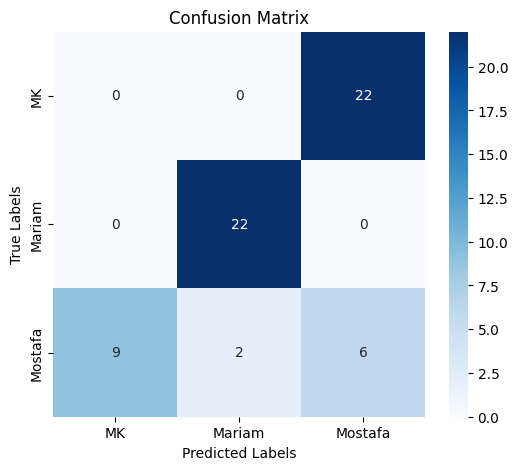

In [ ]:
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': range(1, 30),
    'weights': ['uniform', 'distance'],
    #'uniform': All neighbors have equal weight in the classification decision
    #This means each of the k nearest neighbors contributes the same amount to the decision-making process, regardless of how far or close they are.
    #'distance': Neighbors closer to the query point are given more weight
    #Specifically, the closer a neighbor is to the query point, the greater its influence on the prediction
    'metric': ['minkowski', 'euclidean', 'manhattan'],
    'p': [1, 2]  # Only relevant for Minkowski
    #p=1: the distance metric is equivalent to the Manhattan distance (L1 norm).
    #p=2: the distance metric becomes the Euclidean distance (L2 norm), which is the straight-line distance
}

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_knn = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

training_accuracy = best_knn.score(X_train, y_train)
testing_accuracy = best_knn.score(X_test, y_test)
print(f"Training Accuracy: {training_accuracy:.4f}")
print(f"Testing Accuracy: {testing_accuracy:.4f}")

y_pred = best_knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

joblib_file = 'optimized_biometrics_model.pkl'
joblib.dump(best_knn, joblib_file)
#verify
model = joblib.load(joblib_file)

In [ ]:
results_df = pd.DataFrame(grid_search.cv_results_)

results_df = results_df[['param_n_neighbors', 'param_weights', 'param_metric', 'param_p', 'mean_test_score', 'std_test_score', 'rank_test_score']]
results_df = results_df.dropna()
results_df.sample(10)


,param_n_neighbors,param_weights,param_metric,param_p,mean_test_score,std_test_score,rank_test_score
15,4,distance,minkowski,2,1.0,0.0,1
225,28,distance,euclidean,1,1.0,0.0,1
139,6,distance,euclidean,2,1.0,0.0,1
10,3,uniform,minkowski,2,1.0,0.0,1
23,6,distance,minkowski,2,1.0,0.0,1
93,24,distance,minkowski,1,1.0,0.0,1
62,16,uniform,minkowski,2,1.0,0.0,1
36,10,uniform,minkowski,1,1.0,0.0,1
94,24,uniform,minkowski,2,1.0,0.0,1
155,10,distance,euclidean,2,1.0,0.0,1


In [ ]:
def predict_person(input_data):

    model = joblib.load('optimized_biometrics_model.pkl')

    prediction = model.predict(input_data)

    return prediction[0]

predicted_person = predict_person(dfS3_test.drop("target",axis=1))
print(f"The predicted person is: {predicted_person}")

The predicted person is: Mariam
